IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, confusion_matrix

LOAD DATASET

In [2]:
df = pd.read_csv("up_election_2021_300_candidates.csv")
df.head()


,Candidate Name,Party,Experience,Vote Received,Win Location (District),Win %,Loss %,Age,Gender,Education,Constituency
0,Ravi Saxena,AIMIM,23 Years,243716,Kanpur,55.86,44.14,36,Male,Graduate,Kanpur Sadar
1,Ankit Khan,INC,3 Years,130836,Lucknow,37.14,62.86,49,Male,Diploma,Lucknow Sadar
2,Rahul Tripathi,Apna Dal,5 Years,98138,Noida,49.62,50.38,70,Male,Post Graduate,Noida Sadar
3,Pooja Mishra,SP,16 Years,188095,Bareilly,59.05,40.95,49,Male,Post Graduate,Bareilly Sadar
4,Ruchi Sharma,BJP,16 Years,88518,Ayodhya,59.04,40.96,32,Male,Post Graduate,Ayodhya Sadar


DATA CLEANING AND PRE-PROCESSING

In [3]:
df["Experience"] = df["Experience"].str.extract("(\d+)").astype(int)


df.fillna({
    "Age": df["Age"].median(),
    "Vote Received": df["Vote Received"].median(),
    "Win %": df["Win %"].median(),
    "Loss %": df["Loss %"].median(),
}, inplace=True)

df.head()


,Candidate Name,Party,Experience,Vote Received,Win Location (District),Win %,Loss %,Age,Gender,Education,Constituency
0,Ravi Saxena,AIMIM,23,243716,Kanpur,55.86,44.14,36,Male,Graduate,Kanpur Sadar
1,Ankit Khan,INC,3,130836,Lucknow,37.14,62.86,49,Male,Diploma,Lucknow Sadar
2,Rahul Tripathi,Apna Dal,5,98138,Noida,49.62,50.38,70,Male,Post Graduate,Noida Sadar
3,Pooja Mishra,SP,16,188095,Bareilly,59.05,40.95,49,Male,Post Graduate,Bareilly Sadar
4,Ruchi Sharma,BJP,16,88518,Ayodhya,59.04,40.96,32,Male,Post Graduate,Ayodhya Sadar


VISUALIZATIONS

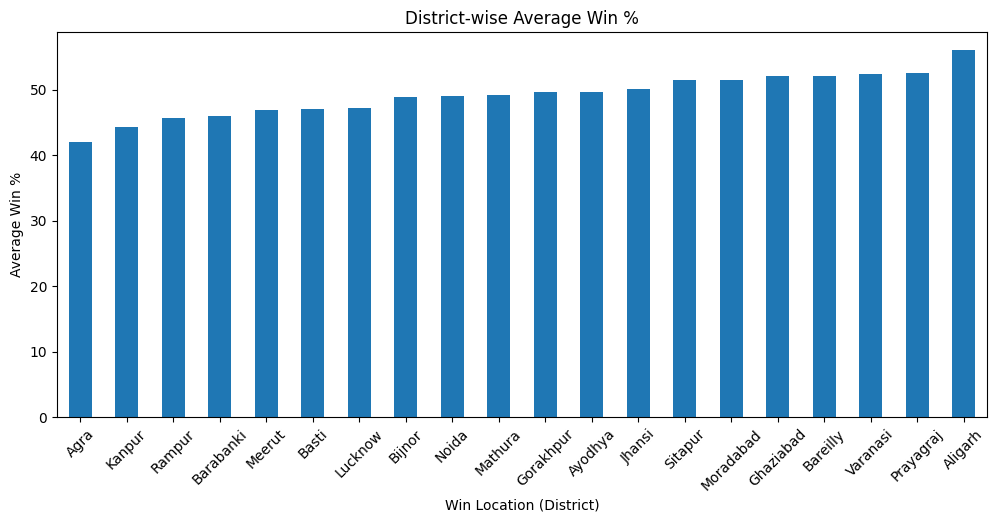

In [4]:
plt.figure(figsize=(12,5))
df.groupby("Win Location (District)")["Win %"].mean().sort_values().plot(kind="bar")
plt.title("District-wise Average Win %")
plt.ylabel("Average Win %")
plt.xticks(rotation=45)
plt.show()

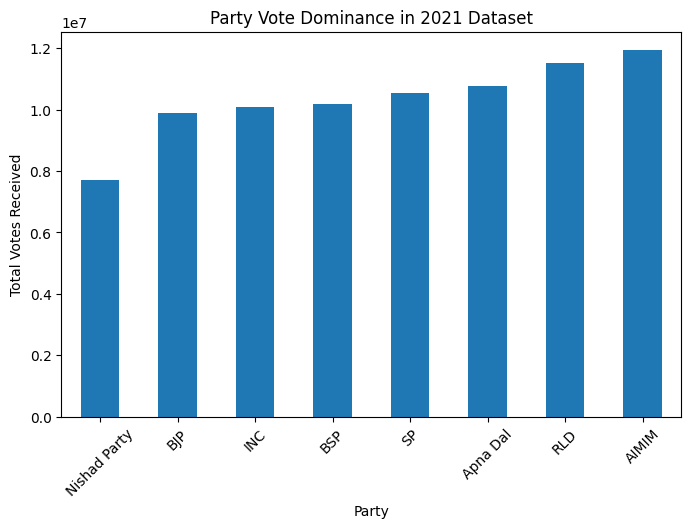

In [5]:
plt.figure(figsize=(8,5))
df.groupby("Party")["Vote Received"].sum().sort_values().plot(kind="bar")
plt.title("Party Vote Dominance in 2021 Dataset")
plt.ylabel("Total Votes Received")
plt.xticks(rotation=45)
plt.show()

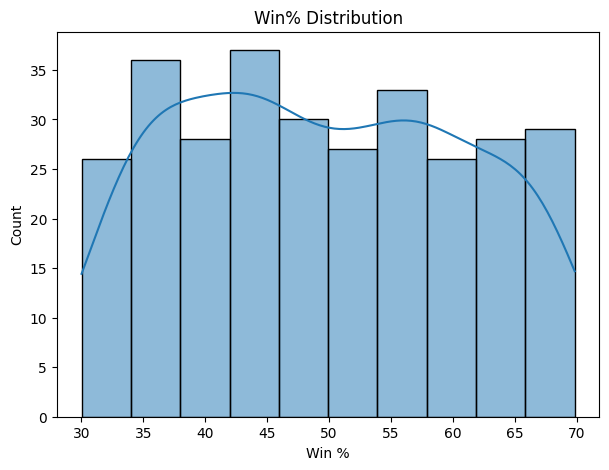

In [6]:
plt.figure(figsize=(7,5))
sns.histplot(df["Win %"], kde=True)
plt.title("Win% Distribution")
plt.show()

FEATURING AND SCALING

In [7]:
df["Result"] = (df["Win %"] > 50).astype(int)  # Win=1, Loss=0

features = ["Party","Experience","Vote Received","Win Location (District)","Age","Gender","Education"]
X = df[features]
y_reg = df["Win %"]
y_clf = df["Result"]

cat_cols = ["Party","Win Location (District)","Gender","Education"]
num_cols = ["Experience","Vote Received","Age"]

In [8]:
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

reg_model = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))
])

clf_model = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])

MODEL TRAINING

In [10]:
X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)
reg_model.fit(X_train, y_reg_train)
reg_pred = reg_model.predict(X_test)

X_train2, X_test2, y_clf_train, y_clf_test = train_test_split(X, y_clf, test_size=0.2, random_state=42)
clf_model.fit(X_train2, y_clf_train)
clf_pred = clf_model.predict(X_test2)


MODEL EVALUATION

1. REGRESSION

In [11]:
print("MAE (Regression):", mean_absolute_error(y_reg_test, reg_pred))

MAE (Regression): 10.079532500000004


2. CLASSIFICATION

Accuracy: 0.5166666666666667
              precision    recall  f1-score   support

           0       0.46      0.62      0.52        26
           1       0.60      0.44      0.51        34

    accuracy                           0.52        60
   macro avg       0.53      0.53      0.52        60
weighted avg       0.54      0.52      0.52        60



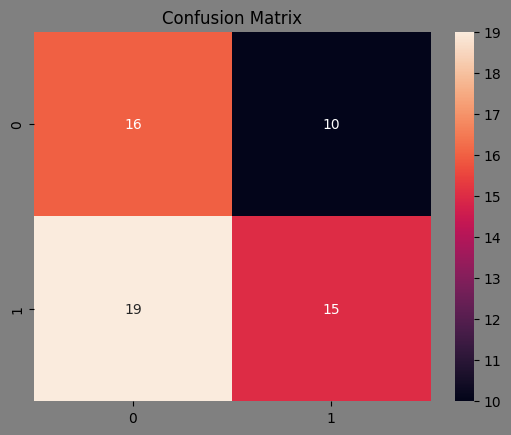

In [27]:
print("Accuracy:", accuracy_score(y_clf_test, clf_pred))
print(classification_report(y_clf_test, clf_pred))
plt.figure(facecolor='grey') 
sns.heatmap(confusion_matrix(y_clf_test, clf_pred), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

PREDICTION

In [14]:
def predict_candidate(name, party, experience, votes, district, age, gender, edu):
    new_data = pd.DataFrame([{
        "Party": party, 
        "Experience": experience, 
        "Vote Received": votes,
        "Win Location (District)": district,
        "Age": age, 
        "Gender": gender, 
        "Education": edu
    }])

    win_percent = reg_model.predict(new_data)[0]
    result = clf_model.predict(new_data)[0]
    result_label = "Win" if result == 1 else "Lose"

    print(f"Candidate: {name}")
    print(f"Predicted Win %: {win_percent:.2f}")
    print(f"Predicted Result: {result_label}")


In [19]:
predict_candidate(
    name="Ravi Saxena",
    party="AIMIM",
    experience=23,
    votes=243716,
    district="Kanpur",
    age=36,
    gender="Male",
    edu="Graduate"
)


Candidate: Ravi Saxena
Predicted Win %: 53.74
Predicted Result: Win
